In [1]:
!pip install --upgrade matplotlib

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed

In [3]:
from numpy.random import seed
seed(0)
import tensorflow as tf
tf.random.set_seed(0)

In [4]:
stocks = pd.read_csv('stocks.csv', index_col=0)
new_stocks = pd.read_csv('actualStocks.csv', index_col=0)

In [5]:
stocks.head()

,btcClose,ethClose,adaClose
date,,,
2017-10-01,4403.740234,302.337006,0.024969
2017-10-02,4409.319824,297.475006,0.025932
2017-10-03,4317.479980,292.463013,0.020816
2017-10-04,4229.359863,292.657990,0.021931
2017-10-05,4328.410156,295.863007,0.021489


In [6]:
new_stocks.head()

,btcClose,ethClose,adaClose
date,,,
2021-07-13,32702.025391,1940.083984,1.265083
2021-07-14,32822.347656,1994.331299,1.262258
2021-07-15,31780.730469,1911.175659,1.223192
2021-07-16,31421.539063,1880.382935,1.173715
2021-07-17,31533.068359,1898.825195,1.172302


In [7]:
monovariable_stocks = stocks['btcClose']
monovariable_new_stocks = stocks['btcClose']
monovariable_stocks.head()

date
2017-10-01    4403.740234
2017-10-02    4409.319824
2017-10-03    4317.479980
2017-10-04    4229.359863
2017-10-05    4328.410156
Name: btcClose, dtype: float64

In [8]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

def build_prediction_dataframe(training_ts, predictions_ts):
  last_training_predictions = [training_ts.tail(1), predictions_ts]
  last_training_predictions_ts = pd.concat(last_training_predictions)
  last_training_predictions_df = last_training_predictions_ts.reset_index()
  last_training_predictions_df['positive_delta'] = last_training_predictions_df.apply(lambda row: row.name > 0 and last_training_predictions_df.loc[row.name-1, :][last_training_predictions_df.columns[1]] < row[last_training_predictions_df.columns[1]], axis=1)
  predictions_df = last_training_predictions_df.iloc[1: , :][['positive_delta']]
  return predictions_df

def add_row_confusion_matrix(list_of_cm, df_row):
  row = 0
  column = 0
  if df_row.positive_delta_predict:
    column = 1
  if df_row.positive_delta_actual:
    row = 1
  list_of_cm[df_row.name-1][row, column] += 1
  return list_of_cm

def evaluate(model, train_ts, test_ts, n_evaluations=10, n_test=3, n_steps=1, n_epochs=100, batch_size=16, full_test=False):
  total_hits = 0
  total_tries = 0
  confusion_matrix = [np.zeros((2,2)), np.zeros((2,2)), np.zeros((2,2))]
  print('Training on train_ts')
  # This line is to replicate the other script

  model.train(train_ts, n_epochs, batch_size)

  print('Iteration 1 started on test')
  steps_to_predict = test_ts[:n_steps]
  steps_result = test_ts[n_steps:n_steps+n_test]
  if full_test:
    i=1
    while n_steps + (n_test * i) < len(test_ts):
      steps_to_predict_model = pd.concat([steps_to_predict, steps_result])
      predictions = model.predict(steps_to_predict_model)
      predictions = predictions.reshape(predictions.shape[0])
      predictions_ts = pd.DataFrame({steps_to_predict.columns[0]: predictions}, steps_result.index)

      predictions_df = build_prediction_dataframe(steps_to_predict, predictions_ts)
      predictions_df.rename(columns={'positive_delta': 'positive_delta_predict'}, inplace=True)

      test_df = build_prediction_dataframe(steps_to_predict, steps_result)
      test_df.rename(columns={'positive_delta': 'positive_delta_actual'}, inplace=True)

      predictions_and_test = pd.concat([test_df, predictions_df], axis=1)
      predictions_and_test['equal'] = predictions_and_test.apply(lambda row: row['positive_delta_actual'] == row['positive_delta_predict'], axis=1)
      predictions_and_test.apply(lambda row: add_row_confusion_matrix(confusion_matrix, row), axis=1)

      hits = predictions_and_test['equal'].sum()
      print('Accuracy: {}/{}'.format(hits, predictions_and_test.shape[0]))
      total_hits += hits
      total_tries += predictions_and_test.shape[0]

      print('Iteration {} started'.format(i))
      new_train = pd.concat([steps_to_predict, steps_result])
      model.retrain(new_train, epochs=1, batch_size=len(new_train), validation_split=0)
      steps_to_predict = test_ts[(n_test * (i-1)):n_steps + (n_test * (i-1))]
      steps_result = test_ts[n_steps + (n_test * (i-1)):n_steps + (n_test * i)]
      i+=1
  else:
    for i in reversed(range(1, n_evaluations + 1)):
      print('Last training {} {}'.format(i, steps_to_predict))
      steps_to_predict_model = pd.concat([steps_to_predict, steps_result])
      predictions = model.predict(steps_to_predict_model)
      predictions = predictions.reshape(predictions.shape[0])
      predictions_ts = pd.DataFrame({steps_to_predict.columns[0]: predictions}, test_evaluate.index)
      
      predictions_df = build_prediction_dataframe(steps_to_predict, predictions_ts)
      predictions_df.rename(columns={'positive_delta': 'positive_delta_predict'}, inplace=True)
      
      test_df = build_prediction_dataframe(steps_to_predict, steps_result)
      test_df.rename(columns={'positive_delta': 'positive_delta_actual'}, inplace=True)

      predictions_and_test = pd.concat([test_df, predictions_df], axis=1)
      predictions_and_test['equal'] = predictions_and_test.apply(lambda row: row['positive_delta_actual'] == row['positive_delta_predict'], axis=1)
      predictions_and_test.apply(lambda row: add_row_confusion_matrix(confusion_matrix, row), axis=1)

      hits = predictions_and_test['equal'].sum()
      print('Accuracy: {}/{}'.format(hits, predictions_and_test.shape[0]))
      total_hits += hits
      total_tries += predictions_and_test.shape[0]

      print('Iteration {} started'.format(n_evaluations + 1 - i))
      new_train = pd.concat([steps_to_predict, test_evaluate])
      model.retrain(new_train, epochs=1, batch_size=len(new_train), validation_split=0)
      steps_to_predict = new_train[-n_steps:]

  print('Total hits: {}. Total tries: {}. Accuracy: {:0.2f}'.format(total_hits, total_tries, total_hits / total_tries))
  
  return confusion_matrix

In [9]:
def plot_confusion_matrix(confusion_matrix):
  fig, axs = plt.subplots(2, 2)
  fig.supxlabel('Predicted')
  fig.supylabel('Actual')
  for i in range(0, len(confusion_matrix)):
    ax = axs[int(i/2), i%2]
    ax.title.set_text('Index {}'.format(i+1))
    sns.heatmap(data=confusion_matrix[i], annot=True, cbar=False, ax=ax)
  sum_cm = sum(confusion_matrix)
  axs[1,1].title.set_text('Total')
  sns.heatmap(data=sum_cm, annot=True, cbar=False, ax=axs[1,1])

In [10]:
from VanillaMultivariableLSTM import VanillaLSTM
from StackedMultivariableLSTM import StackedLSTM
from BidirectionalMultivariableLSTM import BidirectionalLSTM
from ConvMultivariableLSTM import ConvLSTM
from CnnMultivariableLSTM import CnnLSTM

n_outputs = 1
n_features = 3
n_evaluations = 10
epochs = 50
n_neurons = 30
batch_size = 16
n_steps = 5
n_seed = 0
optimizer = 'adam'
loss = 'mean_squared_error'
model_type = ConvLSTM

seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons,n_features=n_features, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, stocks, new_stocks, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size, full_test=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 4, 64)          34560     
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 34,817
Trainable params: 34,817
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/50
78/78 [==============================] - 3s 8ms/step - loss: 0.0119 - accuracy: 8.0775e-04 - val_loss: 0.0428 - val_accuracy: 0.0000e+00
Epoch 2/50
78/78 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 8.0775e-04 - val_loss: 0.0308 - val_accuracy: 0.0000e+00
Epoch 3/50
78/78 [==============================] - 0s 4ms/s

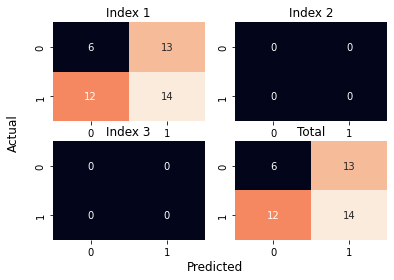

In [11]:
plot_confusion_matrix(cm)